In this colab, we :       


1.   connect to APIs to get the interest and discount rates
2.   Model the stock price path using Montecarlo
3.   Implement a simple payoff structure for an Autocall
4.   Compute its price



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import requests
import csv
from io import StringIO
from datetime import datetime, timedelta

## Suggestions

We can stop the montecarlo at obs dates instead of maturity because there is no good in keeping the diffusion until maturity if a coupon will be called in 1 period.

Implemented code to get riskless free rate for any maturity ( spot forward rates of AAA bonds in
euro area) to use as discounting rates in price computations.

Implemented code to get the euro-overnight rate considered as spot riskless rate.

The code is more flexible

*   works for different levels of autocalls barriers correponding to different observation dates.
*   Works for different maturities and number of observations
*   We can easily add different coupons for each observation.

Changed the payoff in the case of reimbursement below 100%.

Conducted tests in extreme values of Autocalls barriers and protection barriers for different observation frequency and the results were correct each time.

Question : 1-can the barrier level be superior to the autocall level ? If so say the AT = 100, BP = 200 and the return of the stock is 1.2, and assume there were no callback, do we say that the BP is crossed ?
2-Should i annualize the vol by multiplaying by sqrt 252 or 365 ?  



Reference : https://www.hedios.com/sites/default/files/others/certificate/Term%2520Sheet_H%2520Absolu.pdf





In [ ]:
today_date = datetime.today()
previous_date = today_date - timedelta(days=7)
previous_date_formatted = previous_date.strftime('%Y-%m-%d')
url = f'https://sdw-wsrest.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y?startPeriod={previous_date_formatted}&format=csvdata'

response = requests.get(url)
if response.status_code == 200:
    data = response.text
    reader = csv.DictReader(StringIO(data))

    for row in reader:
        rate = row['OBS_VALUE']
    print(rate)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")



3.3184649059


In [ ]:
def get_forward_riskless_rates(T,freq_obs):
  '''
  T : Maturity of the product
  freq_obs : it is T * number of observations in a year.
            example for 2 observations for a maturity of 3 years
            freq_obs is 6
  Output : riskless forward rates for different observation times.
  '''
  def generate_time_periods(T, freq_obs):
    obs_times = []
    i = 0
    step = T/freq_obs
    while i < T :
      i = i+step
      j = i*12
      months = j%12
      years = j//12
      if years == 0:
        obs_times.append(str(int(months))+'M')
      elif months == 0:
        obs_times.append(str(int(years))+'Y')
      else:
        obs_times.append(str(int(years))+'Y'+str(int(months))+'M')
    print(obs_times)
    return obs_times

  def get_rate(mat):
    '''
    mat : observation dates computed by the above function
    '''
    today_date = datetime.today()
    previous_date = today_date - timedelta(days=7)
    previous_date_formatted = previous_date.strftime('%Y-%m-%d')

    url = f'https://sdw-wsrest.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_{mat}?startPeriod={previous_date_formatted}&format=csvdata'

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.text
            reader = csv.DictReader(StringIO(data))
            for row in reader:
                rate = row['OBS_VALUE']
            return float(rate)/100
            # return float(rate)/100
        else:
            print(f"Request failed with status code {response.status_code}")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")


  list_rates = []
  time_periods=generate_time_periods(T, freq_obs)
  for tp in time_periods :
      list_rates.append(get_rate(tp))
  return list_rates

In [ ]:
get_forward_riskless_rates(4,8)

['6M', '1Y', '1Y6M', '2Y', '2Y6M', '3Y', '3Y6M', '4Y']


[0.03601990776,
 0.032865283041,
 0.030382295048,
 0.02844529147,
 0.026951200659,
 0.02581550834,
 0.024968950626000002,
 0.024354795725999998]

In [ ]:
def get_spot_riskless_rate():

  '''
  Output : the spot euro overnight interchange rate considered as the riskless rate
  '''
  today_date = datetime.today()
  delta = timedelta(days=3) + timedelta(weeks=4)
  target_date = today_date - delta
  url = f'https://sdw-wsrest.ecb.europa.eu/service/data/FM/M.U2.EUR.4F.MM.UONSTR.HSTA?startPeriod=2024-03&format=csvdata'

  try:
      response = requests.get(url)
      if response.status_code == 200:
          data = response.text
          reader = csv.DictReader(StringIO(data))
          for row in reader:
              rate = row['OBS_VALUE']
      else:
          print(f"Request failed with status code {response.status_code}")

  except requests.exceptions.RequestException as e:
      print(f"Error fetching data: {e}")
  return float(rate)/100

In [ ]:
get_spot_riskless_rate()

0.039066000000000004

In [ ]:
def data_imports(ticker,period):
  ticker = yf.Ticker(ticker)
  historical_data = ticker.history(period=period)
  return historical_data

In [ ]:
def get_hist_vol(data):
  returns = data['Close'].pct_change()
  vol = np.std(np.array(returns)[1:])
  return vol*np.sqrt(252)

In [ ]:
ticker = '^STOXX50E'
period = '1mo'
historical_data = data_imports(ticker,period)
sigma = get_hist_vol(historical_data)

r = get_spot_riskless_rate()

In [ ]:
sigma = 0.2
r = 0

In [ ]:
def simulate_stock(S0,T,N,r,d,sigma):
  '''
  S0 : Initial stock price
  T : Maturity of the autocall
  N : number of paths
  r : interest rate
  sigma : volatility
  d : dividend
  Output : A matrix of N lines and 365*T columns presenting the evolution of the stock price
  '''
  S0_vec = np.full(N,S0)
  S_matrix = np.zeros((N,365*T))
  S_matrix[:,0] = S0_vec
  timestep = 1/(T*365)
  rand_matrix = np.zeros((N,S_matrix.shape[1]-1))
  for i in range(S_matrix.shape[1]-1):
    rand_vec = np.random.normal(0,1,size=N)
    rand_matrix[:,i] = rand_vec
    S_matrix[:,i+1] = S_matrix[:,i] * np.exp(((r-d-(sigma**2)/2)*timestep + sigma*np.sqrt(timestep) * rand_vec))
  return S_matrix,rand_matrix

In [ ]:
def plot_stock_path(matrice,T):
  x_axis = np.linspace(0,T,365*T)
  for i in range(matrice.shape[0]):
    plt.plot(x_axis,matrice[i,:])
  plt.show()

In [ ]:
def compute_payoff(S0,T,N,freq_obs,BP,AT,coupon):
  '''
  AT will be a list of Autocall barriers each corresponding to an observation date
  coupon : for now a scaler
  '''

  step_size = (T * 365)/freq_obs
  obs_dates = [int((k+1)*step_size- 1) for k in range(freq_obs)]
  state_matrix = np.ones((N,freq_obs))
  evaluation_matrix = S_matrix[:,obs_dates]/S0
  # evaluation_matrix = np.array([[1.20371427, 1.12631269, 1.24810408,1.20371427, 1.12631269, 1.24810408,1.20371427, 1.12631269, 1.24810408,1.20371427, 1.12631269, 1.24810408],
  #      [0.97 ,0.93945793,0.97,1.098478455 , 1.098478455, 0.93945793,0.97 , 1.098478455, 0.93945793,0.97 , 1.098478455, 0.93945793],
  #      [0.97558902, 0.19117429, 0.085,0.97558902, 0.19117429, 0.085,0.97558902, 0.19117429, 0.085,0.97558902, 0.19117429, 1.085],
  #      [0.90538683, 0.86595771, 0.79177789,0.90538683, 0.86595771, 0.79177789,0.90538683, 0.86595771, 0.79177789,0.90538683, 0.86595771, 0.79177789],
  #      [0.94335983, 0.99043135, 0.85,0.94335983, 0.99043135, 0.85,0.94335983, 0.99043135, 0.85,0.94335983, 0.99043135, 0.85]])
  payoff_coupon_matrix = np.zeros((N,freq_obs))
  payoff_kg_matrix = np.zeros((N,freq_obs))
  obs = 0
  while obs < freq_obs:
    for i in range(evaluation_matrix.shape[0]):
      if evaluation_matrix[i,obs]>=AT[obs]:
        payoff_coupon_matrix[i,obs] = ((1+obs)*T/freq_obs)*coupon*np.min(state_matrix[i,:])
        payoff_kg_matrix[i,obs] = 1*np.min(state_matrix[i,:])
        state_matrix[i,obs] = 0
      else :
        payoff_coupon_matrix[i,obs] = 0
        payoff_kg_matrix[i,obs] = 0
    obs = obs +1

  #Final date
  comparison_AT = (evaluation_matrix[:, -1] >= AT[freq_obs-1])
  comparison_BP = (evaluation_matrix[:, -1] < AT[freq_obs-1]) & (evaluation_matrix[:, -1] >= BP)

  payoff_coupon_matrix[:,-1] = np.where(comparison_AT,(freq_obs*T/freq_obs)*coupon*np.min(state_matrix[:,:freq_obs - 1],axis=1),0)
  payoff_kg_matrix[:,-1] = np.where(comparison_AT, 1 * np.min(state_matrix[:, :freq_obs - 1],axis=1), 0)
  payoff_kg_matrix[:,-1] = np.where(comparison_BP, 1 * np.min(state_matrix[:, :freq_obs - 1],axis=1), payoff_kg_matrix[:,-1])
  payoff_kg_matrix[:,-1] = np.where(~comparison_AT & ~comparison_BP, 1*np.min(state_matrix[:,:freq_obs - 1],axis=1), payoff_kg_matrix[:,-1])
  payoff_coupon_matrix[:,-1] = np.where(~comparison_AT & ~comparison_BP, -(1-evaluation_matrix[:, -1])*np.min(state_matrix[:,:freq_obs - 1],axis=1),payoff_coupon_matrix[:,-1])
  payoff_matrix = payoff_coupon_matrix + payoff_kg_matrix

  print(payoff_coupon_matrix)
  print(payoff_kg_matrix)
  return evaluation_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matrix

In [ ]:
S0 = 100
T=3
N=1000
d = 0
r = 0
S_matrix, rand_matrix = simulate_stock(S0,T,N,r,d,sigma)

In [ ]:
rand_matrix

array([[-0.5197861 ,  1.98781967,  1.58961203, ...,  1.70849493,
        -0.83049074,  0.32533285],
       [ 0.23755134, -0.9769254 , -1.96371093, ...,  1.72135399,
        -0.57420017, -0.11727397],
       [ 0.31853061, -1.66598194, -0.75082113, ...,  0.96078658,
         0.73823321, -1.7761808 ],
       ...,
       [ 0.31483239, -0.43250412, -0.15473789, ...,  0.60480666,
        -0.06469881, -1.80435254],
       [ 0.34256408,  1.82901211,  0.4851626 , ..., -1.91024821,
         1.53613354,  0.70295683],
       [-0.16443484, -0.28502587, -0.02630234, ...,  0.99884101,
         2.41954101,  0.28942429]])

In [ ]:
np.savetxt('matrix.csv', rand_matrix, delimiter=',')

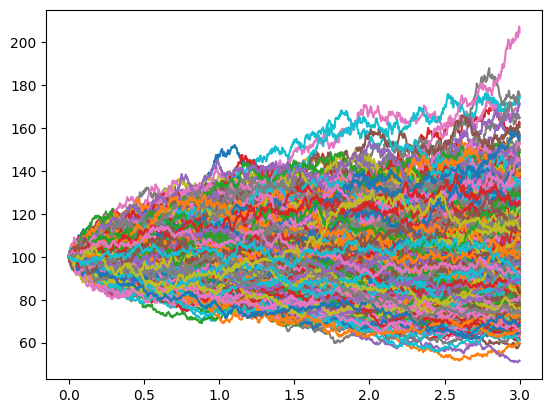

In [ ]:
plot_stock_path(S_matrix,T)

In [ ]:
eval_matrix

array([[1.20371427, 1.12631269, 1.24810408, 1.20371427, 1.12631269,
        1.24810408, 1.20371427, 1.12631269, 1.24810408, 1.20371427,
        1.12631269, 1.24810408],
       [0.97      , 0.93945793, 0.97      , 1.09847845, 1.09847845,
        0.93945793, 0.97      , 1.09847845, 0.93945793, 0.97      ,
        1.09847845, 0.93945793],
       [0.97558902, 0.19117429, 0.085     , 0.97558902, 0.19117429,
        0.085     , 0.97558902, 0.19117429, 0.085     , 0.97558902,
        0.19117429, 1.085     ],
       [0.90538683, 0.86595771, 0.79177789, 0.90538683, 0.86595771,
        0.79177789, 0.90538683, 0.86595771, 0.79177789, 0.90538683,
        0.86595771, 0.79177789],
       [0.94335983, 0.99043135, 0.85      , 0.94335983, 0.99043135,
        0.85      , 0.94335983, 0.99043135, 0.85      , 0.94335983,
        0.99043135, 0.85      ]])

In [ ]:
freq_obs = 3
coupon = 0.0
N = 1000
BP = 1
# N=5
# for AT in [[0,0,0,0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,1,1],[100,100,100,100,100,100,100,100,100,100,100,100]]:
#   for BP in [0,1,100]:
#     print(AT,BP)
#     eval_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matri = compute_payoff(S0,T,N,freq_obs,BP,AT,coupon)
BP = 1
# for AT in [[0,0,0,0,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,1,1],[100,100,100,100,100,100,100,100,100,100,100,100]]:
#   print(AT,BP)
#   eval_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matri = compute_payoff(S0,T,N,freq_obs,BP,AT,coupon)
AT = [1,1,1]
eval_matrix,payoff_coupon_matrix,payoff_kg_matrix,state_matrix,payoff_matri = compute_payoff(S0,T,N,freq_obs,BP,AT,coupon)

In [ ]:
np.mean(payoff_kg_matrix,axis = 0)

array([0.471, 0.131, 0.398])

In [ ]:
eval_matrix

In [ ]:
def compute_price(notional,matrice,r,T,freq_obs):
  price = 0
  # discount_rates = get_forward_riskless_rates(T,freq_obs)
  discount_rates = np.zeros(3)
  for i in range(freq_obs):
    price = price + np.mean(matrice[:,i]) * np.exp(-discount_rates[i]*T*(i+1)/freq_obs)
  return price*notional

In [ ]:
notional = 100
compute_price(notional,payoff_matri,r,T,freq_obs)

93.93473666337862

In [ ]:
# try to resume all that  - verification done !
# Le rendre plus modulable : plusieurs barrieres differente une pour chaque année - done!
# dig in the folders philippe sent and see what you can do
# write a function to bootstrap to interest curve
# plusieurs taux possible